In [70]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

In [71]:
df_neg_pi_mc = pd.read_parquet("/home/mdicosta/hf_pid_studies/distributions/distributions/k0s/pbpb/neg_pi_eff_df_mc.parquet", engine="pyarrow") 
df_pos_pi_mc = pd.read_parquet("/home/mdicosta/hf_pid_studies/distributions/distributions/k0s/pbpb/pos_pi_eff_df_mc.parquet", engine="pyarrow") 
df_neg_pi = pd.read_parquet("/home/mdicosta/hf_pid_studies/distributions/distributions/k0s/pbpb/neg_pi_eff_df.parquet", engine="pyarrow") 
df_pos_pi = pd.read_parquet("/home/mdicosta/hf_pid_studies/distributions/distributions/k0s/pbpb/pos_pi_eff_df.parquet", engine="pyarrow") 

In [72]:
df_neg_pi_mc

,fCentralityFT0C,fOccupancyFt0c,fPt,fNSigmaTpcPosPi,fNSigmaTpcPosPi_unc,fNSigmaTpcNegPi,fNSigmaTpcNegPi_unc,fNSigmaTofPosPi,fNSigmaTofPosPi_unc,fNSigmaTofNegPi,fNSigmaTofNegPi_unc
0,"[0, 50)","[0, 40000)","[1.0, 3)","[0.9227173233115638, 0.8940760875138396, 0.844...","[0.0001535871835505791, 0.00017699614535248036...","[0.8959215936122135, 0.852890438333335, 0.7836...","[0.0001756284548926818, 0.00020372608298274223...","[0.9972054426386338, 0.9544544708452047, 0.682...","[3.0361861574623463e-05, 0.0001199168042014391...","[0.9973162590112732, 0.9545619792664221, 0.682...","[2.975543549251866e-05, 0.00011978193661132189..."
1,"[0, 50)","[40000, 9999999)","[1.0, 3)","[0.9161510739137878, 0.8911263146260752, 0.847...","[0.0002040061561711609, 0.00022926727517819779...","[0.8948662131617556, 0.8588043376971803, 0.801...","[0.00022576737453693297, 0.0002563118972512551...","[0.997131281653422, 0.9543042152551886, 0.6827...","[3.9366889318065494e-05, 0.0001537065816822156...","[0.997226092930221, 0.9545225520811887, 0.6827...","[3.871272510678101e-05, 0.00015335647332127071..."
2,"[50, 100)","[0, 40000)","[1.0, 3)","[0.9408528001826206, 0.9151289758027698, 0.877...","[0.0005144429412218346, 0.000607757255399985, ...","[0.9034726449551058, 0.8628443159336479, 0.803...","[0.0006440090704891761, 0.0007502092311844373,...","[0.9971322858012479, 0.9534032110789834, 0.683...","[0.00011661478065477968, 0.0004596482142458464...","[0.99746518794704, 0.9543591158119008, 0.68199...","[0.00010965565484253311, 0.0004551370758693928..."
3,"[50, 100)","[40000, 9999999)","[1.0, 3)","[0.9429746333729687, 0.9231445699564012, 0.896...","[0.0008161132590009134, 0.0009374293005209419,...","[0.9096190051525961, 0.8788892191835117, 0.838...","[0.0010091011640352523, 0.0011482193364083112,...","[0.9969901902497027, 0.9556207887435593, 0.684...","[0.0001927886004294931, 0.000724767932577497, ...","[0.9975599484740388, 0.9551872770511296, 0.684...","[0.00017363424632721395, 0.0007281340103810903..."


In [73]:
def convert_to_interval(interval_str):
    match = re.match(r"(\[|\()(\d+(\.\d+)?),\s*(\d+(\.\d+)?)(\]|\))", interval_str)
    if match:
        # Extract the left and right bounds, converting them to float
        left = float(match.group(2))  # Group 2 captures the left bound
        right = float(match.group(4))  # Group 4 captures the right bound
        
        # Determine if the interval is closed on the left or right
        closed = 'left' if match.group(1) == '[' else 'right'
        # Return the interval as a pandas Interval
        return pd.Interval(left, right, closed=closed)
    
    # If the string doesn't match the interval format, return None
    return None  

def sort_df_by_interval(df, col):
    # Use .loc[] to safely modify the DataFrame and avoid the SettingWithCopyWarning
    df.loc[:, "lower_bound"] = df[col].apply(lambda x: x.left)  # Extract left bound
    df_sorted = df.sort_values("lower_bound").drop(columns="lower_bound")  # Sort and drop helper column
    return df_sorted

In [74]:
interval_cols = ['fCentralityFT0C', 'fOccupancyFt0c', 'fPt']

for col in interval_cols:
    df_neg_pi_mc[col] = df_neg_pi_mc[col].apply(convert_to_interval) 
    df_pos_pi_mc[col] = df_pos_pi_mc[col].apply(convert_to_interval) 
    df_neg_pi[col] = df_neg_pi[col].apply(convert_to_interval) 
    df_pos_pi[col] = df_pos_pi[col].apply(convert_to_interval)

In [75]:
def draw_efficiencies(df_data, df_mc, diff_col_name, eff_var):
    
    sort_df_data = sort_df_by_interval(df_data, diff_col_name)
    sort_df_mc = sort_df_by_interval(df_mc, diff_col_name)
    # sort_df_data = df_data
    # sort_df_mc = df_mc
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

    lower_bin_bounds = sort_df_data[diff_col_name].apply(lambda x: x.left)
    upper_bin_bounds = sort_df_data[diff_col_name].apply(lambda x: x.right)

    bin_centers = (np.array(lower_bin_bounds) + np.array(upper_bin_bounds)) / 2
    bin_widths = (np.array(upper_bin_bounds) - np.array(lower_bin_bounds)) / 2
    
    n_sigma_vals = [3,2,1]
    for icase, n_sigma in enumerate(n_sigma_vals):
        n_sigma_effs_data = []
        n_sigma_effs_uncs_data = []
        n_sigma_effs_mc = []
        n_sigma_effs_uncs_mc = []
        for entry in range(len(sort_df_data)):
            n_sigma_effs_data.append(sort_df_data.loc[entry, eff_var][icase])
            n_sigma_effs_uncs_data.append(sort_df_data.loc[entry, f"{eff_var}_unc"][icase])
            n_sigma_effs_mc.append(sort_df_mc.loc[entry, eff_var][icase])
            n_sigma_effs_uncs_mc.append(sort_df_mc.loc[entry, f"{eff_var}_unc"][icase])
        
        ax1.errorbar(bin_centers, n_sigma_effs_data, yerr=n_sigma_effs_uncs_data, 
                    xerr=bin_widths, label=f'data, |{eff_var}| < {n_sigma}', fmt='o')
        ax1.errorbar(bin_centers, n_sigma_effs_mc, yerr=n_sigma_effs_uncs_mc, 
                    xerr=bin_widths, label=f'mc, |{eff_var}| < {n_sigma}', fmt='o')

        ratio = np.array(n_sigma_effs_data) / np.array(n_sigma_effs_mc)
        ratio_unc = ratio * np.sqrt((np.array(n_sigma_effs_uncs_data) / np.array(n_sigma_effs_data))**2 + (np.array(n_sigma_effs_uncs_mc) / np.array(n_sigma_effs_mc))**2)
        ax2.errorbar(bin_centers, ratio, yerr=ratio_unc, xerr=bin_widths, label=f'|{eff_var}| < {n_sigma}', fmt='o')

    # min_eff = 1
    # max_eff = 0
    # if np.array(effs).flatten()[np.array(effs).flatten()!=0].min() < min_eff:
    #     min_eff = np.array(effs).flatten()[np.array(effs).flatten()!=0].min()
    # if np.array(effs).flatten().max() > max_eff:
    #     max_eff = np.array(effs).flatten().max()

    # min_ratio = 1000
    # max_ratio = 0
    # if ratio[~np.isnan(ratio)].min() < min_ratio:
    #     min_ratio = ratio[~np.isnan(ratio)].min()
    # if ratio[~np.isnan(ratio)].max() > max_ratio:
    #     max_ratio = ratio[~np.isnan(ratio)].max()

    ax1.set_ylabel('Efficiency')
    # ax1.set_ylim(min_eff.min()/2, 1.2)
    ax1.legend()
    ax1.set_yscale('log')
    ax1.grid(True)

    ax2.set_xlabel(r'$p_T$ (GeV/$c$)')
    ax2.set_ylabel('Data / MC')
    # ax2.set_ylim(min_ratio*0.95, max_ratio*1.05)
    ax2.legend()
    ax2.grid(True)

    return fig

In [76]:
# cent_df_neg_pi_data = df_neg_pi.query('fCentralityFT0C == @pd.Interval(0., 50., closed="left")')
# cent_df_neg_pi_mc = df_neg_pi_mc.query('fCentralityFT0C == @pd.Interval(0., 50., closed="left")')
# fig_occ_neg_pi = draw_efficiencies(cent_df_neg_pi_data, cent_df_neg_pi_mc, 'fOccupancyFt0c', 'fNSigmaTpcNegPi')

In [77]:
occ_df_neg_pi_data

,fCentralityFT0C,fOccupancyFt0c,fPt,fNSigmaTpcPosPi,fNSigmaTpcPosPi_unc,fNSigmaTpcNegPi,fNSigmaTpcNegPi_unc,fNSigmaTofPosPi,fNSigmaTofPosPi_unc,fNSigmaTofNegPi,fNSigmaTofNegPi_unc,lower_bound
0,"[0.0, 50.0)","[0.0, 40000.0)","[1.0, 3.0)","[0.9042827514963213, 0.8766707935431469, 0.812...","[0.0005841895243783099, 0.0006529166988537522,...","[0.9003398758782756, 0.8650905678529465, 0.779...","[0.0005947993607171527, 0.0006783572706007696,...","[0.968800025234404, 0.9049333259732989, 0.6271...","[0.0003452238015459477, 0.0005824102098375803,...","[0.9712564367444465, 0.9033798329797889, 0.627...","[0.00033177510568672, 0.0005866453411118729, 0...",0.0
1,"[50.0, 100.0)","[0.0, 40000.0)","[1.0, 3.0)","[0.955864532176797, 0.9293003380317623, 0.8592...","[0.001159892827533616, 0.0014474798886757918, ...","[0.9453090120543401, 0.9113463868869188, 0.817...","[0.0012840165027999363, 0.001605150580742347, ...","[0.9894444798775432, 0.9416097965431469, 0.669...","[0.0005771136627870917, 0.0013241320589185855,...","[0.9835129791440781, 0.9323936475540532, 0.670...","[0.0007190961499604105, 0.0014178138931350338,...",50.0


  fCentralityFT0C  fOccupancyFt0c         fPt  \
0     [0.0, 50.0)  [0.0, 40000.0)  [1.0, 3.0)   
1   [50.0, 100.0)  [0.0, 40000.0)  [1.0, 3.0)   

                                     fNSigmaTpcPosPi  \
0  [0.9042827514963213, 0.8766707935431469, 0.812...   
1  [0.955864532176797, 0.9293003380317623, 0.8592...   

                                 fNSigmaTpcPosPi_unc  \
0  [0.0005841895243783099, 0.0006529166988537522,...   
1  [0.001159892827533616, 0.0014474798886757918, ...   

                                     fNSigmaTpcNegPi  \
0  [0.9003398758782756, 0.8650905678529465, 0.779...   
1  [0.9453090120543401, 0.9113463868869188, 0.817...   

                                 fNSigmaTpcNegPi_unc  \
0  [0.0005947993607171527, 0.0006783572706007696,...   
1  [0.0012840165027999363, 0.001605150580742347, ...   

                                     fNSigmaTofPosPi  \
0  [0.968800025234404, 0.9049333259732989, 0.6271...   
1  [0.9894444798775432, 0.9416097965431469, 0.669...   

       

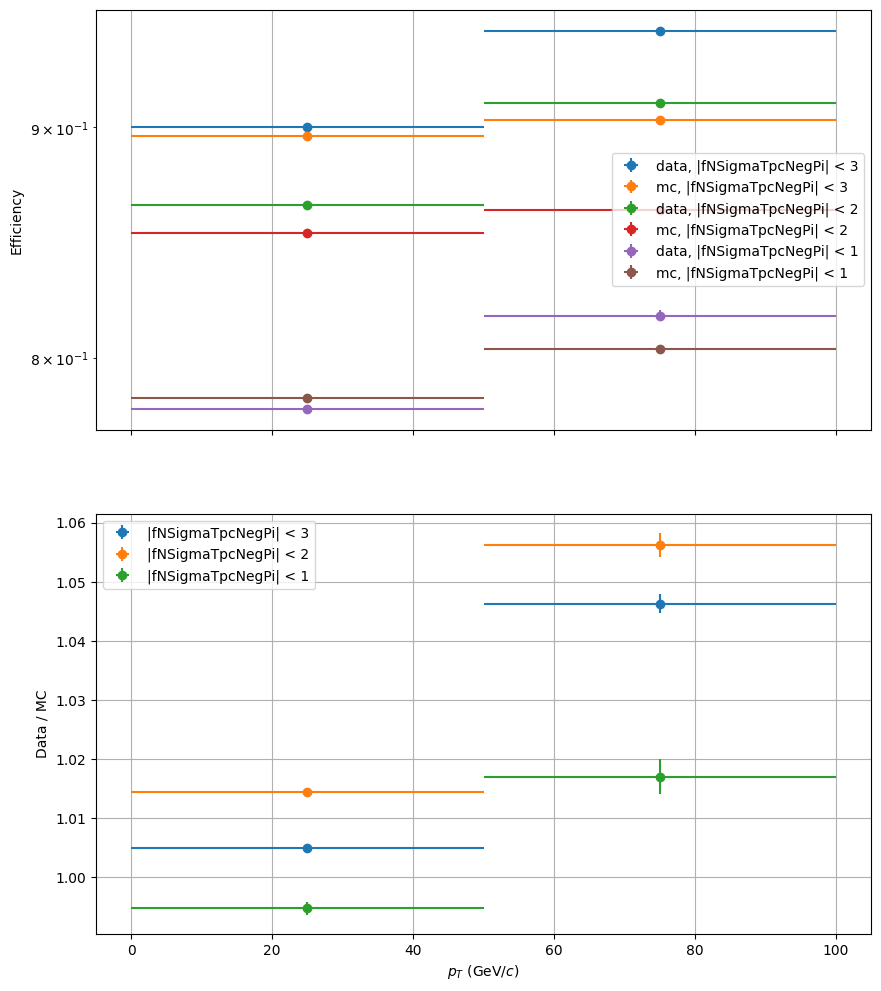

In [78]:
occ_df_neg_pi_data = df_neg_pi.query('fOccupancyFt0c == @pd.Interval(0., 40000., closed="left")').reset_index(drop=True)
occ_df_neg_pi_mc = df_neg_pi_mc.query('fOccupancyFt0c == @pd.Interval(0., 40000., closed="left")').reset_index(drop=True)
fig_cent_neg_pi = draw_efficiencies(occ_df_neg_pi_data, occ_df_neg_pi_mc, 'fCentralityFT0C', 'fNSigmaTpcNegPi')